# ECG classification

Laurent Cetinsoy - Datadidacte


### **Author** : Lina Farchado

In [37]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mlbiocsv/ecg_small_dataset.csv
/kaggle/input/mlbiology/nsr.txt
/kaggle/input/mlbiology/chf.txt
/kaggle/input/mlbiology/arr.txt
/kaggle/input/mlbiobigcsv/ecg_big_dataset.csv


In [38]:
!pip install pywavelets

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [39]:
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pywt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## A first naive model by extracting simple features


Your environment contains variables arr, nsr, and chf which respectively contain 10-second recordings of ECG signals extracted from three datasets on PhysioNet: one from a person suffering from arrhythmia, one from a person with a normal heart rhythm, and another from a person with heart failure.


Matplotlib  subplots (or any other library), display these signals on three subfigures (the subplots should be called with the parameter nrows = 3).
Can you find any differences between them?

In [40]:
arr = np.loadtxt('/kaggle/input/mlbiology/arr.txt')
chf = np.loadtxt('/kaggle/input/mlbiology/chf.txt')
nsr = np.loadtxt('/kaggle/input/mlbiology/nsr.txt')

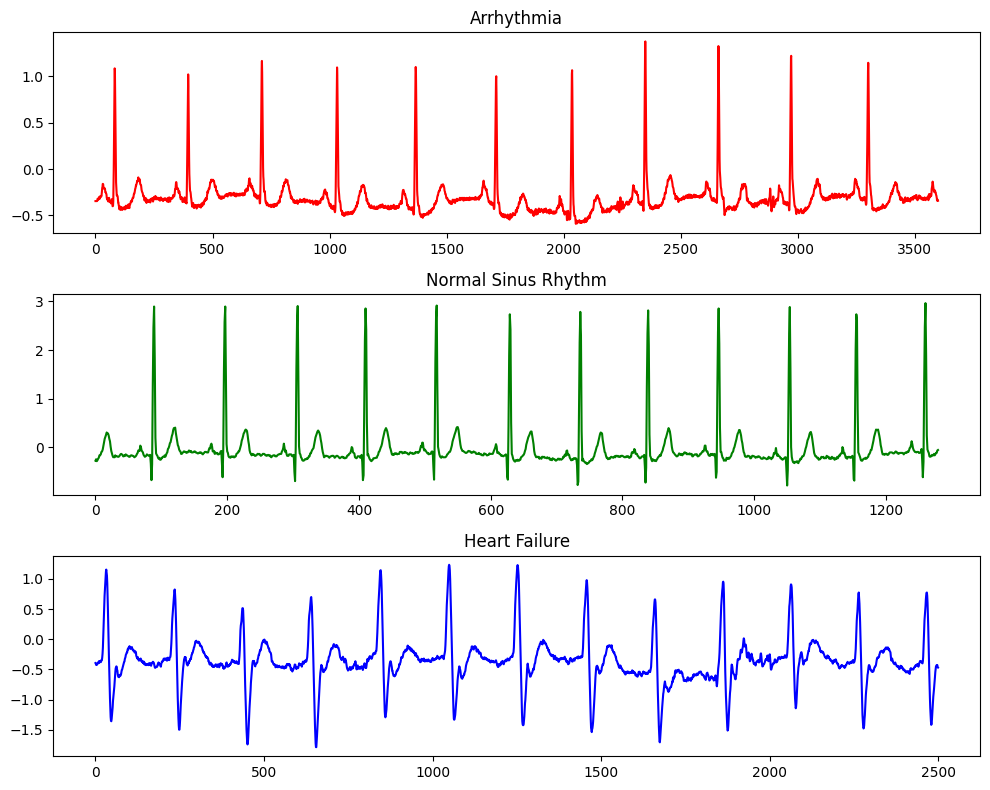

In [41]:
fig, axs = plt.subplots(nrows=3, figsize=(10, 8))

axs[0].plot(arr, color='red')
axs[0].set_title('Arrhythmia')

axs[1].plot(nsr, color='green')
axs[1].set_title('Normal Sinus Rhythm')

axs[2].plot(chf, color='blue')
axs[2].set_title('Heart Failure')

plt.tight_layout()
plt.show()

- Le signal d'arythmie est le plus irrégulier, avec des intervalles et des amplitudes variables.
- Le rythme sinusal normal est le plus constant et le plus régulier.
- Le signal d'insuffisance cardiaque présente des irrégularités et des changements d'amplitude qui le différencient à la fois du rythme normal et de l'arythmie.

We want to extract features from the time series. For that we will use simple statistics.


Create a function named calculate_stats_features(x) that calculates some statistical features of a signal x using standard numpy functions: nanpercentile, nanmean, etc.
calculate_stats_features will return a list of features in this order:

0. Max
1. Min
2. Mean
3. Median
4. Variance

In [42]:
def calculate_stats_features(x):
    return [
        np.nanmax(x),
        np.nanmin(x),
        np.nanmean(x),
        np.nanmedian(x),
        np.nanvar(x)
    ]



Create a function named `calculate_zero_crossing(x)` that calculates the Zero
Crossing of a signal x.

The zero crossing is defined as the number of times the signal changes sign.
For this, you can use the signbit, diff, and nonzero functions from numpy.


In [43]:
def calculate_zero_crossing(x):
    return np.sum(np.diff(np.signbit(x)))

Create a function named **calculate_rms(x)** that returns the Root Mean Square (RMS) of a signal x. We will use the nanmean function instead of the mean function from numpy.

In [44]:
def calculate_rms(x):
    return np.sqrt(np.nanmean(np.square(x)))

Create a function named calculate_entropy(x) that calculates the Shannon entropy of a signal x using the entropy function from scipy.stats.

In [45]:
def calculate_entropy(x):
    values, counts = np.unique(x, return_counts=True)
    probabilities = counts / counts.sum()
    return stats.entropy(probabilities)

Create a function get_features(x) that combines the features calculated by all previous functions including caculate_stats_features.

In [46]:
def get_features(x):
    return calculate_stats_features(x) + [
        calculate_zero_crossing(x), 
        calculate_rms(x), 
        calculate_entropy(x)
    ]

Load the small ecg dataset

In [47]:
small_ecg = pd.read_csv('/kaggle/input/mlbiocsv/ecg_small_dataset.csv')
small_ecg = small_ecg.drop(columns='0')
small_ecg

,1,2,3,4,5,6,7,8,9,10,...,15352,15353,15354,15355,15356,15357,15358,15359,15360,15361
0,1,-0.429539,-0.431368,-0.427633,-0.453029,-0.460659,-0.448497,-0.469340,-0.475054,-0.473138,...,-0.299412,-0.341126,-0.364847,-0.360565,-0.358913,-0.406275,-0.452011,-0.440424,-0.417412,-0.419938
1,1,-0.527040,-0.542357,-0.539678,-0.541406,-0.518841,-0.505650,-0.523337,-0.532713,-0.520244,...,-0.523533,-0.542245,-0.544550,-0.523466,-0.510608,-0.497607,-0.508469,-0.495939,-0.479749,-0.484566
2,2,-0.410425,-0.416644,-0.424048,-0.398195,-0.393680,-0.386315,-0.371686,-0.377065,-0.368017,...,-0.288222,-0.742357,-1.088831,-1.347331,-1.349561,-1.165759,-1.004126,-0.829844,-0.671777,-0.536377
3,2,-0.007009,-0.069041,-0.063572,-0.080944,-0.070556,-0.098701,-0.090165,-0.108852,-0.074475,...,-1.906522,-1.694052,-1.534222,-1.338660,-1.167661,-0.989236,-0.777201,-0.544748,-0.313120,-0.032588
4,0,-0.325000,-0.395000,-0.255000,-0.335000,-0.375000,-0.335000,-0.285000,-0.275000,-0.245000,...,-0.085000,-0.105000,-0.135000,-0.135000,-0.155000,-0.155000,-0.135000,-0.145000,-0.125000,-0.115000
5,0,-0.185000,-0.155000,-0.125000,-0.115000,-0.105000,-0.095000,-0.085000,-0.065000,-0.025000,...,-0.105000,-0.135000,-0.145000,-0.145000,-0.155000,-0.165000,-0.165000,-0.145000,-0.155000,-0.135000


Use your fonction get_features create a new dataframe where you have all the feature as X and y as the label.

In [48]:
y = small_ecg.iloc[:, 0]
X = small_ecg.iloc[:, 1:]

# Extraire les caractéristiques pour chaque signal ECG
X_features = X.apply(get_features, axis=1)

# Transformer la liste des caractéristiques en DataFrame
df_features = pd.DataFrame(X_features.tolist(), columns=[
    'max', 'min', 'mean', 'median', 'variance', 
    'zero_crossings', 'rms', 'entropy'
])
df_features

,max,min,mean,median,variance,zero_crossings,rms,entropy
0,1.002118,-0.592731,-0.340759,-0.376057,0.032634,358,0.385683,9.639522
1,-0.281521,-0.923734,-0.510468,-0.505293,0.003658,0,0.514039,9.639522
2,1.235749,-2.492697,-0.344063,-0.354895,0.146738,418,0.514895,9.639522
3,1.295494,-3.105455,-0.195126,-0.133382,0.721041,384,0.871272,9.639522
4,2.445000,-1.005000,-0.046349,-0.105000,0.133627,1150,0.368477,6.237319
5,1.645000,-1.265000,-0.077669,-0.115000,0.064813,812,0.266167,5.676426


Train a random forest on it after doing a train test split if the dataset is not too small

In [49]:
def train_rf(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return rf, accuracy, classification_report(y_test, y_pred)

In [50]:
rf_features, accuracy_features, classification_report_features = train_rf(df_features, y)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

In [51]:
print(f'Accuracy on test set: {accuracy_features}')
print("Classification Report:\n")

print(f'{classification_report_features}')

Accuracy on test set: 0.0
Classification Report:

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       2.0
           2       0.00      0.00      0.00       0.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



Now you have a first pipeline, do the same on the full dataset
Report the train and test loss

In [52]:
big_ecg = pd.read_csv('/kaggle/input/mlbiobigcsv/ecg_big_dataset.csv')
big_ecg = big_ecg.drop(columns='0')
big_ecg.head()

/tmp/ipykernel_30/2478626832.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  big_ecg = pd.read_csv('/kaggle/input/mlbiobigcsv/ecg_big_dataset.csv')


,1,2,3,4,5,6,7,8,9,10,...,65528,65529,65530,65531,65532,65533,65534,65535,65536,65537
0,1,-0.060085,0.001638,-0.014941,-0.018776,-0.110048,-0.160348,-0.196445,-0.287140,-0.383509,...,-0.145316,-0.088612,0.001568,0.066026,0.154291,0.214976,0.227396,0.172451,0.011588,-0.154281
1,1,-0.467585,-0.650931,-0.595663,-0.627657,-0.552164,-0.532318,-0.500500,-0.486974,-0.480109,...,0.273010,0.279927,0.213876,0.137012,0.019218,-0.031818,-0.068809,-0.068333,-0.178109,-0.136239
2,1,-0.155555,-0.229827,-0.207653,-0.210114,-0.191253,-0.184057,-0.152477,-0.171106,-0.159727,...,-1.238173,-1.112138,-0.812259,-0.595419,-0.444057,-0.326833,-0.117486,-0.038309,-0.015658,0.004507
3,1,0.099644,0.098019,0.089555,0.108130,0.070369,0.083866,0.073525,0.061310,0.081658,...,-0.291689,-0.111845,0.180895,0.373213,0.486517,0.394578,0.283331,0.169355,0.166666,0.146715
4,1,-0.368856,-0.530640,-0.487672,-0.447722,-0.276366,-0.292531,-0.236326,-0.209993,-0.174277,...,-0.546984,-0.427314,-0.527221,-0.588838,-0.624649,-0.577075,-0.652600,-0.500391,-0.386848,-0.161838


In [53]:
y_big = big_ecg.iloc[:, 0]
X_big = big_ecg.iloc[:, 1:]

# Extract features from ECG
X_features_big = X_big.apply(get_features, axis=1)

df_features_big = pd.DataFrame(X_features_big.tolist(), columns=[
    'max', 'min', 'mean', 'median', 'variance', 
    'zero_crossings', 'rms', 'entropy'
])
df_features_big.head()

,max,min,mean,median,variance,zero_crossings,rms,entropy
0,3.006143,-2.460911,-0.268554,-0.346791,0.420271,4154,0.701707,11.090355
1,2.527708,-3.550697,-0.221014,-0.106818,0.536639,3768,0.765171,11.090355
2,2.264555,-3.929179,-0.163022,-0.153941,0.182135,2253,0.456849,11.090355
3,3.055421,-1.906982,0.053962,0.051409,0.158568,3102,0.401846,11.090355
4,2.035001,-1.575197,-0.148872,-0.174830,0.111417,4748,0.365486,11.090355


In [54]:
rf_features_big, accuracy_features_big, classification_report_features_big = train_rf(df_features_big, y_big)
print("Classification Report:\n")

print(f'{classification_report_features_big}')
print(f'Accuracy on test set: {accuracy_features_big:.2f}')

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.83      1.00      0.90        19
           2       1.00      0.50      0.67         6

    accuracy                           0.88        33
   macro avg       0.94      0.79      0.83        33
weighted avg       0.90      0.88      0.87        33

Accuracy on test set: 0.88


try to tweak the model hyperparameter to see if it works

In [55]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

X_train_big, X_test_big, y_train_big, y_test_big = train_test_split(df_features_big, y_big, test_size=0.2, random_state=42)

grid_search = GridSearchCV(estimator=rf_features_big, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_big, y_train_big)

best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [56]:
y_pred_big = best_rf.predict(X_test_big)
print(f'Best Parameters: {grid_search.best_params_}')
print("Classification Report:\n")
print(f'{classification_report(y_test_big, y_pred_big)}')
print(f'Accuracy on test set: {accuracy_score(y_test_big, y_pred_big):.2f}')

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.86      1.00      0.93        19
           2       1.00      0.50      0.67         6

    accuracy                           0.91        33
   macro avg       0.95      0.83      0.86        33
weighted avg       0.92      0.91      0.90        33

Accuracy on test set: 0.91


## Fourier transform features

We want now to see if a model using only fourier transform could work.

create a function get_fourier_coefficients(ecg)

In [57]:
def get_fourier_coefficients(ecg, n_coeffs=50):
    fourier_transform = np.fft.fft(ecg)
    fourier_coeffs = np.abs(fourier_transform[:n_coeffs])
    return fourier_coeffs

Using this function create a dataframe df_fourrier containing the fourrier transform coefficients and the label

In [58]:
def create_fourier_dataframe(ecg_df, n_coeffs=50):
    fourier_data = []
    
    for index, row in ecg_df.iterrows():
        label = row[0]
        ecg_signal = row[1:]
        fourier_coeffs = get_fourier_coefficients(ecg_signal, n_coeffs=n_coeffs)
        
        fourier_data.append(np.concatenate([[label], fourier_coeffs]))
    
    fourier_columns = ['label'] + [f'fourier_{i}' for i in range(n_coeffs)]
    df_fourier = pd.DataFrame(fourier_data, columns=fourier_columns)
    
    return df_fourier

Try to train a model using the Fourrier coefficient

In [59]:
df_fourier = create_fourier_dataframe(big_ecg)

X_fourier = df_fourier.drop('label', axis=1)
y_fourier = df_fourier['label']

rf_fourier, accuracy_fourier, classification_report_fourier = train_rf(X_fourier, y_fourier)

/tmp/ipykernel_30/2325102117.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[0]


In [60]:
print("Classification Report:\n")

print(f'{classification_report_fourier}')
print(f'Accuracy on test set: {accuracy_fourier:.2f}')

Classification Report:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         8
         1.0       0.83      1.00      0.90        19
         2.0       1.00      0.33      0.50         6

    accuracy                           0.88        33
   macro avg       0.94      0.78      0.80        33
weighted avg       0.90      0.88      0.85        33

Accuracy on test set: 0.88


Try to learn a model using both fourrier coefficient and the features from the previous sections. Does it work ?

In [61]:
df_fourier_features = pd.concat([df_fourier, df_features_big], axis=1)
X_fourier_features = df_fourier_features.drop('label', axis=1)
y_fourier_features = df_fourier_features['label']

rf_fourier_features, accuracy_fourier_features, classification_report_fourier_features = train_rf(X_fourier_features, y_fourier_features)

In [62]:
print("Classification Report:\n")

print(f'{classification_report_fourier_features}')
print(f'Accuracy on test set: {accuracy_fourier_features:.2f}')

Classification Report:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         8
         1.0       0.82      0.95      0.88        19
         2.0       0.67      0.33      0.44         6

    accuracy                           0.85        33
   macro avg       0.83      0.76      0.77        33
weighted avg       0.83      0.85      0.83        33

Accuracy on test set: 0.85


## Wavelets

We now wants to use another signal decomposition which are called wavelet. Wavelet are a multi-scale function decomposition on a familly of functions generated from what is called a mother wavelet.

Using PyWavelet make a function get_wavelet_coefficients(ecg) that returns the wavelet coefficient of a given ECG


In [63]:
def get_wavelet_coefficients(ecg):
    coeffs = pywt.wavedec(ecg, 'db4', level=5)
    return np.concatenate(coeffs)

Using the get_wavelet_coefficients, create a dataframe when the features are the coefficients and include the label

In [64]:
def create_wavelet_features(X):
    wavelet_features = X.apply(lambda x: get_wavelet_coefficients(x), axis=1)
    return pd.DataFrame(wavelet_features.tolist())

In [65]:
df_wavelet = create_wavelet_features(big_ecg)

Train a random forest classifier with such features. DOes the model work

In [66]:
rf_wavelet, accuracy_wavelet, classification_report_wavelet = train_rf(df_wavelet, y_big)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
print("Classification Report:\n")

print(f'{classification_report_wavelet}')
print(f'Accuracy on test set: {accuracy_wavelet:.2f}')

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.66      1.00      0.79        19
           2       0.00      0.00      0.00         6

    accuracy                           0.70        33
   macro avg       0.55      0.50      0.49        33
weighted avg       0.62      0.70      0.62        33

Accuracy on test set: 0.70


Add one or several of the previous feature functions and try to train another model

In [68]:
# Combine wavelet features with previous features
df_wavelet_str = df_wavelet
df_wavelet_str.columns = df_wavelet_str.columns.astype(str)
df_wavelet_features = pd.concat([df_wavelet_str, df_features_big], axis=1)

rf_wavelet_features, accuracy_wavelet_features, classification_report_wavelet_features = train_rf(df_wavelet_features, y_big)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
print("Classification Report:\n")

print(f'{classification_report_wavelet_features}')
print(f'Accuracy on test set: {accuracy_wavelet_features:.2f}')

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.61      1.00      0.76        19
           2       0.00      0.00      0.00         6

    accuracy                           0.64        33
   macro avg       0.54      0.42      0.39        33
weighted avg       0.60      0.64      0.53        33

Accuracy on test set: 0.64


In [70]:
df_wavelet_fourier = pd.concat([df_wavelet_str, df_fourier], axis=1)

rf_wavelet_fourier, accuracy_wavelet_fourier, classification_report_wavelet_fourier = train_rf(df_wavelet_fourier, y_big)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
print("Classification Report:\n")

print(f'{classification_report_wavelet_fourier}')
print(f'Accuracy on test set: {accuracy_wavelet_fourier:.2f}')

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.68      1.00      0.81        19
           2       0.00      0.00      0.00         6

    accuracy                           0.73        33
   macro avg       0.56      0.54      0.53        33
weighted avg       0.63      0.73      0.65        33

Accuracy on test set: 0.73


In [72]:
def train_mlp(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    train_loss = mlp.loss_
    test_loss = log_loss(y_test, mlp.predict_proba(X_test))
    accuracy = accuracy_score(y_test, y_pred)
    return mlp, accuracy, classification_report(y_test, y_pred), train_loss, test_loss

mlp_wavelet_features, accuracy_mlp, classification_report_mlp, train_loss, test_loss = train_mlp(df_wavelet_features, y_big)

In [73]:
print("\nMulti-layer Perceptron analysis:")
print(f'Classification Report:\n{classification_report_mlp}')
print(f'Accuracy on test set: {accuracy_mlp:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Test loss: {test_loss:.4f}')


Multi-layer Perceptron analysis:
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.25      0.29         8
           1       0.54      0.68      0.60        19
           2       0.33      0.17      0.22         6

    accuracy                           0.48        33
   macro avg       0.40      0.37      0.37        33
weighted avg       0.45      0.48      0.46        33

Accuracy on test set: 0.48
Train loss: 0.0005
Test loss: 2.9953


Specify the methodology you used to train the model and report the various attempts results into a table

In [74]:
results = {
    'Methodology': ['Wavelet', 'Wavelet and Features', 'Wavelet and Features'],
    'Model' : ['Random Forest', 'Random Forest', 'MLP'],
    'Accuracy': [accuracy_wavelet, accuracy_wavelet_features, accuracy_mlp]
}
df = pd.DataFrame(results)
print(df)

            Methodology          Model  Accuracy
0               Wavelet  Random Forest  0.696970
1  Wavelet and Features  Random Forest  0.636364
2  Wavelet and Features            MLP  0.484848


## Deep learning (1D CNN)

Now we want to see if we can skip all theses feature engineering techniques !
Design and train a multi-layer one dimensional CNN using the raw ECG signal as features.


Could you reach or surpass the feature based models ?

In [75]:
def train_1d_cnn(X, y, scaler):
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
    
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        Conv1D(256, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    
    # Train Model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Évaluation du modèle
    loss, accuracy = model.evaluate(X_test, y_test)
    return model, accuracy, history

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


I0000 00:00:1735065767.456459     130 service.cc:145] XLA service 0x7a0ad8004780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735065767.456526     130 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-12-24 18:42:59.925003: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng28{k2=1,k3=0} for conv (f32[1,64,1,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,1,65536]{3,2,1,0}, f32[64,32,1,65534]{3,2,1,0}), window={size=1x65534}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-24 18:43:00.729503: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.804641207s
Trying algorithm eng28{k2=1,k3=0} for c

4/4 ━━━━━━━━━━━━━━━━━━━━ 51s 7s/step - accuracy: 0.4039 - loss: 1.6084 - val_accuracy: 0.6154 - val_loss: 0.9479 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 867ms/step - accuracy: 0.5212 - loss: 1.1981 - val_accuracy: 0.6154 - val_loss: 0.9099 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 863ms/step - accuracy: 0.5890 - loss: 1.1776 - val_accuracy: 0.6154 - val_loss: 0.8769 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 859ms/step - accuracy: 0.5659 - loss: 1.0818 - val_accuracy: 0.6154 - val_loss: 0.8669 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 863ms/step - accuracy: 0.6179 - loss: 0.8774 - val_accuracy: 0.6154 - val_loss: 0.8663 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step - accuracy: 0.5629 - loss: 1.1243 - val_accuracy: 0.6154 - val_loss: 0.8746 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 384ms/step - accuracy: 0.6093 - loss: 1.0057 - val_accuracy: 0.6154 

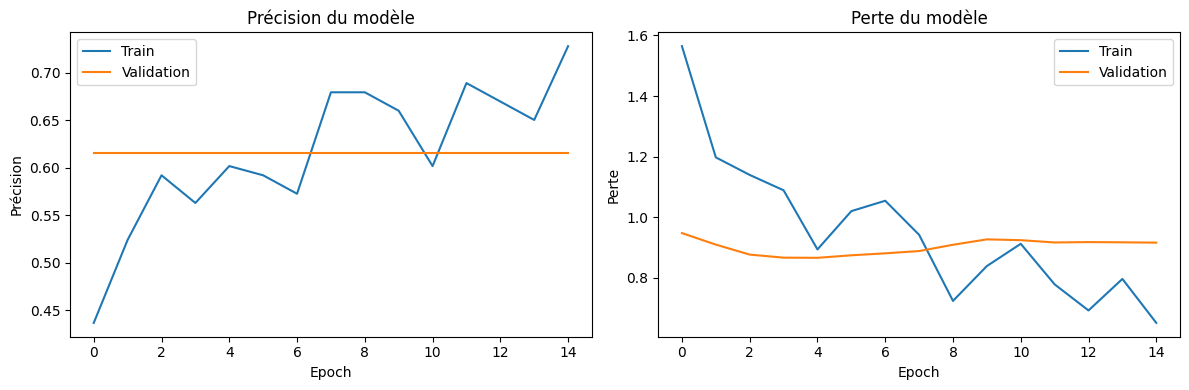

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 420ms/step


In [76]:
scaler = StandardScaler()
cnn_model, cnn_accuracy, cnn_history = train_1d_cnn(X_big, y_big, scaler)

# Tracer l'historique d'entraînement
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Train')
plt.plot(cnn_history.history['val_accuracy'], label='Validation')
plt.title('Précision du modèle')
plt.xlabel('Epoch')
plt.ylabel('Précision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Train')
plt.plot(cnn_history.history['val_loss'], label='Validation')
plt.title('Perte du modèle')
plt.xlabel('Epoch')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()
plt.show()

# Prédictions sur l'ensemble de test
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_big, y_big, test_size=0.2, random_state=42)

X_test_scaled = scaler.transform(X_test_combined)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
y_pred_cnn = cnn_model.predict(X_test_scaled)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

In [77]:
print("Classification Report:\n")

print(f'{classification_report(y_test_combined, y_pred_cnn_classes)}')
print(f'Accuracy on test set: {cnn_accuracy:.2f}')

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.59      1.00      0.75        19
           2       1.00      0.17      0.29         6

    accuracy                           0.61        33
   macro avg       0.53      0.39      0.34        33
weighted avg       0.52      0.61      0.48        33

Accuracy on test set: 0.61


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END max_depth=None, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END max_depth=None, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END max_depth=None, min_samples_split=10, n_estimators=300; total time=   0.7s
[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END 